# Time series forecasting project

In [1]:
# Handle imports up-front
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

### 1. Data loading

In [2]:
raw_data_df=sns.load_dataset("flights")

### 1.2. Inspect

In [3]:

raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


### 1.3. Encode date feature

In [4]:
# Make a copy of the raw data to work with
timeseries_df=raw_data_df.copy()

# Extract the string month to a datetime object feature
timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month

# Use the month and year to create at 'date' datetime feature
timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))

# Set the datetime feature as the index
timeseries_df=timeseries_df.set_index('date')

# Keep only the passenger column
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)

# Re-name 'passengers' to 'dependent_var' so we can easily swap datasets without making
# changes to the notebook
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)

# Check the result
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


## 2. EDA

### 2.1. Baseline model performance

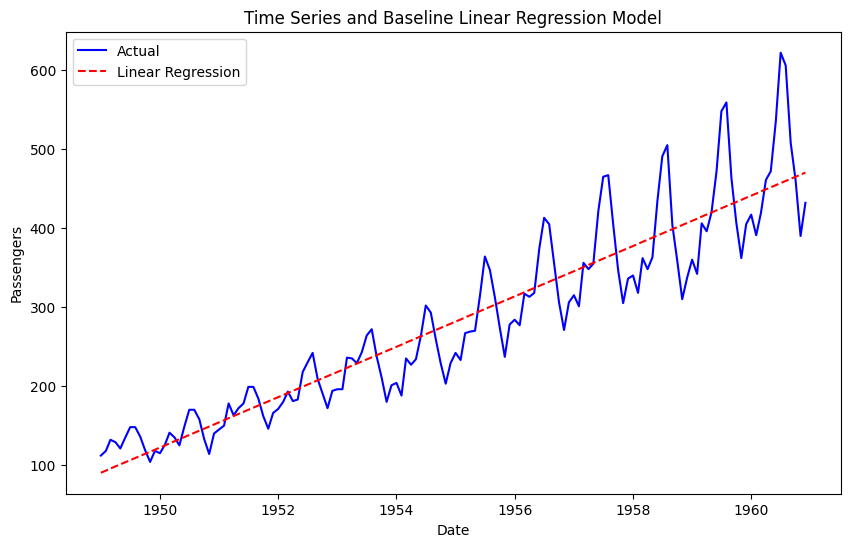

In [5]:
# Creating a numerical range as 'x' for Linear Regression
x = np.arange(len(timeseries_df)).reshape(-1, 1)  # Time indices
y = timeseries_df['dependent_var'].values

# Instantiate and fit the model
lr_model = LinearRegression()
lr_model.fit(x, y)

# Make predictions
lr_predictions = lr_model.predict(x)

# Plot the data and baseline predictions
plt.figure(figsize=(10,6))
plt.plot(timeseries_df.index, y, label='Actual', color='blue')
plt.plot(timeseries_df.index, lr_predictions, label='Linear Regression', color='red', linestyle='--')
plt.title('Time Series and Baseline Linear Regression Model')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### 2.2. Missing, and/or extreme values

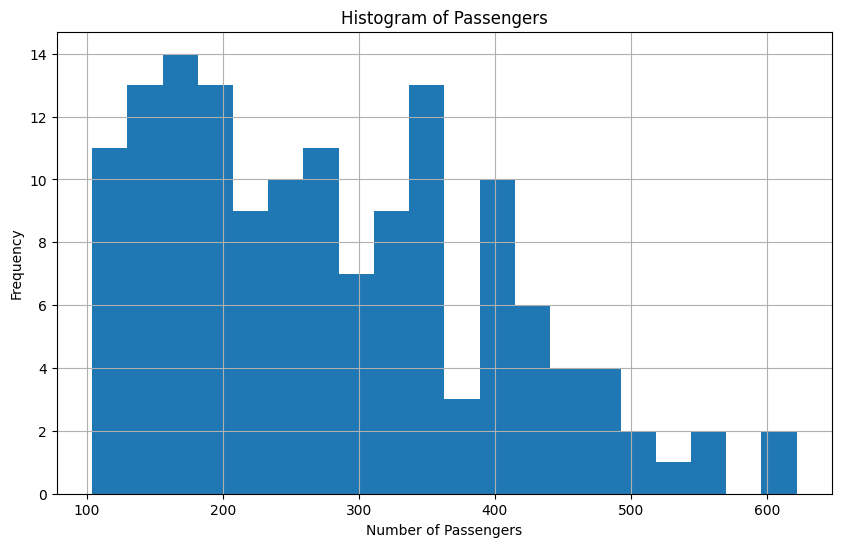

In [6]:
timeseries_df['dependent_var'].hist(bins=20, figsize=(10, 6))
plt.title('Histogram of Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')
plt.show()

### 2.3. Timeseries analysis

### 2.3.1. Plot the time-series

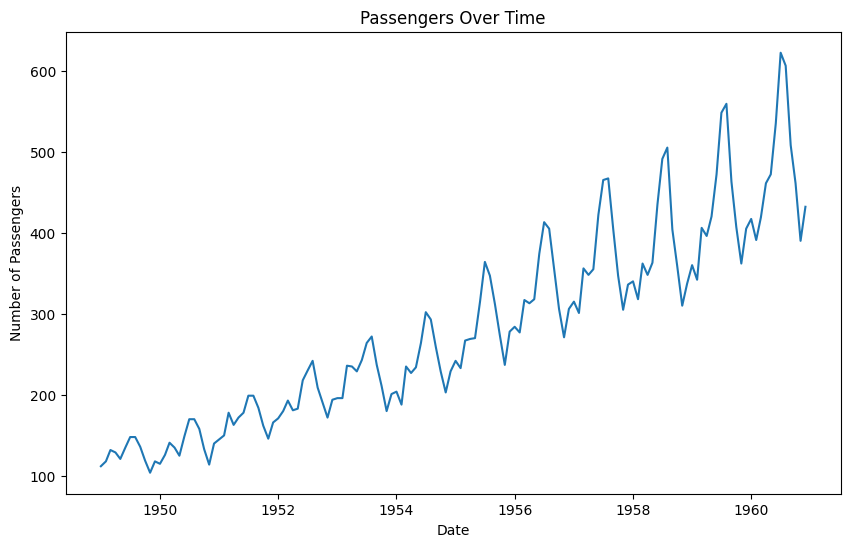

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(timeseries_df.index, timeseries_df['dependent_var'])
plt.title('Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

### 2.3.2. Missing timepoints

In [8]:
# Resample the data by month and check the time difference
time_deltas = timeseries_df.index.to_series().diff().dropna()
print(time_deltas.value_counts())

date
31 days    83
30 days    48
28 days     9
29 days     3
Name: count, dtype: int64


### 2.3.3. Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
adf_result = adfuller(timeseries_df['dependent_var'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Interpret the result
if adf_result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
The series is not stationary.


### 2.3.4. Seasonality

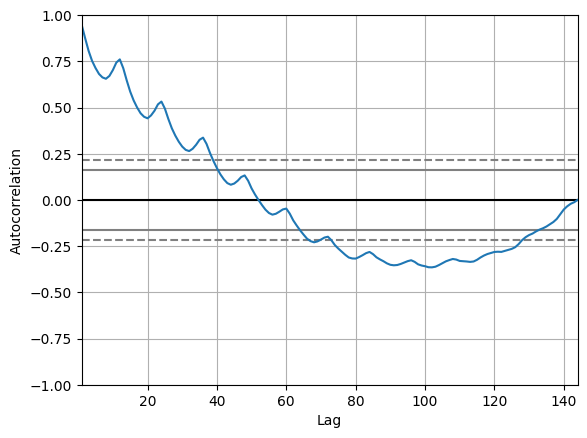

In [10]:
from pandas.plotting import autocorrelation_plot

# Autocorrelation plot
autocorrelation_plot(timeseries_df['dependent_var'])
plt.show()

## 3. Model training

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=0.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.11 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.56 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.19 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.55 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.07 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.14 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.38 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.37 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=0.85 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.04 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.04 sec
 ARIMA(3,1,1)(0,1,0

/tmp/ipykernel_28622/3018636362.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(timeseries_df.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='red')


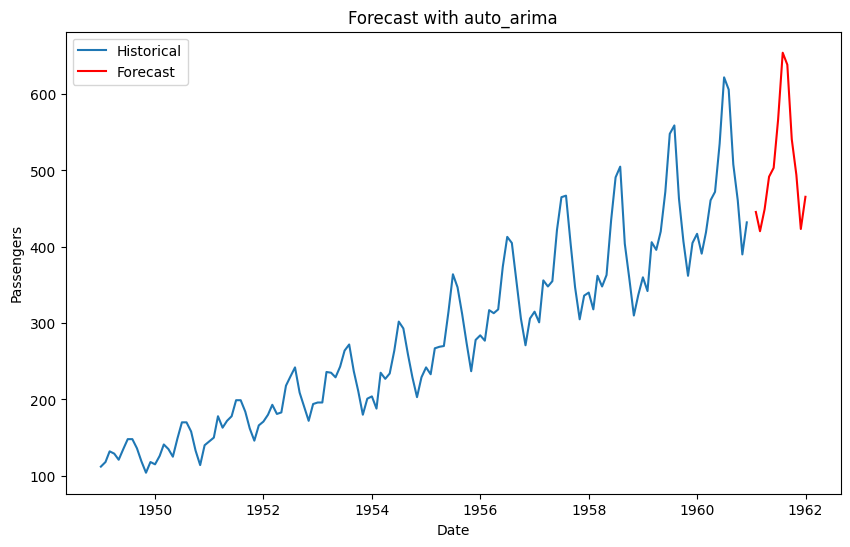

In [11]:
from pmdarima import auto_arima
# Fit the auto_arima model
model = auto_arima(timeseries_df['dependent_var'], seasonal=True, m=12, stepwise=True, trace=True)

# Display model summary
print(model.summary())

# Forecast the next 12 months (for example)
forecast = model.predict(n_periods=12)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Historical')
plt.plot(pd.date_range(timeseries_df.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='red')
plt.title('Forecast with auto_arima')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## 4. Model evaluation


In [12]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Set up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Create a function to evaluate model performance
def evaluate_model(model, data):
    X = np.arange(len(data)).reshape(-1, 1)
    y = data['dependent_var'].values
    mse_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict and calculate MSE
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Evaluate the model performance
mse = evaluate_model(lr_model, timeseries_df)
print(f'Baseline Model MSE: {mse}')

Baseline Model MSE: 2850.3876746462497
